In [2]:
import numpy as np
import pandas as pd
import sys
from sklearn.utils import class_weight
from keras import backend as K
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:


AES_Sbox = np.array(
    [0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76, 0xCA, 0x82, 0xC9,
     0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0, 0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F,
     0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15, 0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07,
     0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75, 0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3,
     0x29, 0xE3, 0x2F, 0x84, 0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58,
     0xCF, 0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8, 0x51, 0xA3,
     0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2, 0xCD, 0x0C, 0x13, 0xEC, 0x5F,
     0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73, 0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88,
     0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB, 0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC,
     0x62, 0x91, 0x95, 0xE4, 0x79, 0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A,
     0xAE, 0x08, 0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A, 0x70,
     0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E, 0xE1, 0xF8, 0x98, 0x11,
     0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF, 0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42,
     0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16])
AES_inv_Sbox = np.array(
    [0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB, 0x7C, 0xE3, 0x39,
     0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB, 0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2,
     0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E, 0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76,
     0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25, 0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC,
     0x5D, 0x65, 0xB6, 0x92, 0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D,
     0x84, 0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06, 0xD0, 0x2C,
     0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B, 0x3A, 0x91, 0x11, 0x41, 0x4F,
     0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73, 0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85,
     0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E, 0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62,
     0x0E, 0xAA, 0x18, 0xBE, 0x1B, 0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD,
     0x5A, 0xF4, 0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F, 0x60,
     0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF, 0xA0, 0xE0, 0x3B, 0x4D,
     0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61, 0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6,
     0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D])

hw = np.array([bin(x).count("1") for x in range(256)])


In [11]:

def load_traces(database_file, start_at=1, number_samples=0, n_features=1):
    # Power Consumption Start_at -> Start_at + Number_Samples
    traces = np.loadtxt(database_file, delimiter=',', dtype=np.float64, skiprows=1,
                        usecols=range(start_at, min(start_at + number_samples, n_features)))
    # Plaintext Start_at - 1
    inputoutput = np.loadtxt(database_file, delimiter=',', dtype=np.str, skiprows=1,
                             usecols=start_at - 1)
    # Chiphertext Start_at + Number_Samples
    # Key Start_at + Number_Samples + 1
    key = np.loadtxt(database_file, delimiter=',', dtype=np.str, skiprows=1,
                             usecols=start_at + number_samples + 1)
    # print("traces shape: {}\ninputoutput shape: {}\n".format(traces.shape, inputoutput.shape))
    return traces, inputoutput, key


# def shorten_traces(dataset, start_at=0, number_samples=0):
#     if len(dataset) == 3:
#         traces, inputoutput, key = dataset
#     elif len(dataset) == 4:
#         traces, inputoutput, key, labels = dataset
# 
#     traces_selected = traces[start_at:start_at + number_samples]
# 
#     if len(dataset) == 3:
#         return traces_selected, inputoutput, key
#     elif len(dataset) == 4:
#         return traces_selected, inputoutput, key, labels


def statcorrect_traces(dataset):
    if len(dataset) == 3:
        traces, inputoutput, key = dataset
    elif len(dataset) == 4:
        traces, inputoutput, key, labels = dataset

    # traces_statcorrect = (traces - np.mean(traces, axis=1).reshape(-1,1))/np.std(traces, axis=1).reshape(-1,1)
    traces_statcorrect = (traces - np.mean(traces, axis=0).reshape(1, -1)) / np.std(traces, axis=0).reshape(1, -1)

    if len(dataset) == 3:
        return traces_statcorrect, inputoutput, key
    elif len(dataset) == 4:
        return traces_statcorrect, inputoutput, key, labels


# Should not need this value with different train and test sets...
# def split_data_percentage(dataset, training_fraction=0.5):
#     if len(dataset) == 2:
#         traces, inputoutput = dataset
#     elif len(dataset) == 3:
#         traces, inputoutput, labels = dataset
#
#     traces_train = traces[:int(traces.shape[0] * training_fraction)]
#     traces_test = traces[int(traces.shape[0] * training_fraction):]
#     inputoutput_train = inputoutput[:int(inputoutput.shape[0] * training_fraction)]
#     inputoutput_test = inputoutput[int(inputoutput.shape[0] * training_fraction):]
#     if len(dataset) == 3:
#         labels_train = labels[:int(labels.shape[0] * training_fraction)]
#         labels_test = labels[int(labels.shape[0] * training_fraction):]
#
#     if len(dataset) == 2:
#         return (traces_train, traces_test), (inputoutput_train, inputoutput_test)
#     elif len(dataset) == 3:
#         return (traces_train, traces_test), (inputoutput_train, inputoutput_test), (labels_train, labels_test)


def create_labels_sboxinputkey(dataset, database_file, col):
    if len(dataset) == 3:
        traces, inputoutput, key = dataset
    else:
        traces, inputoutput, key, _ = dataset

    labels = np.loadtxt(database_file, delimiter=',', dtype=np.int, skiprows=1,
                     usecols=col)
    # labels = np.zeros(inputoutput.shape)
    # for i, v in enumerate(inputoutput):
    #     labels[i] = hw[AES_Sbox[bytes.fromhex(v)[input_index] ^ bytes.fromhex(key[i])[input_index]]]

    return traces, inputoutput, key, labels


In [12]:

# use for hamming weight leakage model
def create_model(classes=9, number_samples=200):
    input_shape = (number_samples, 1)
    trace_input = Input(shape=input_shape)
    x = Conv1D(filters=10, kernel_size=10, strides=10, activation='relu', padding='valid', name='block1_conv1')(
        trace_input)
    x = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='block1_pool')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(50, activation='tanh', name='fc1')(x)
    x = Dense(50, activation='tanh', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(trace_input, x, name='cnn')
    optimizer = SGD(lr=0.01, decay=0, momentum=0, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# use for bit leakage model
def create_big_model(classes=256, number_samples=200):
    input_shape = (number_samples, 1)
    trace_input = Input(shape=input_shape)
    # Block 1
    x = Conv1D(filters=64, kernel_size=10, strides=10, activation='relu', padding='same', name='block1_conv1')(
        trace_input)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same', name='block1_pool')(x)
    # Block 2
    x = Conv1D(filters=128, kernel_size=10, strides=10, activation='relu', padding='same', name='block2_conv1')(
        x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same', name='block2_pool')(x)
    # Block 3
    x = Conv1D(filters=256, kernel_size=10, strides=10, activation='relu', padding='same', name='block3_conv1')(
        x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same', name='block3_pool')(x)
    # Block 4
    x = Conv1D(filters=512, kernel_size=10, strides=10, activation='relu', padding='same', name='block4_conv1')(
        x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same', name='block4_pool')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(50, activation='tanh', name='fc1')(x)
    x = Dense(50, activation='tanh', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(trace_input, x, name='cnn')
    optimizer = SGD(lr=0.01, decay=0, momentum=0, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [13]:
def key_rank(model, inout_test, traces_test, kByte, trueKey):
    p = model.predict(traces_test)
    rank = np.zeros(inout_test.shape[0])
    prob_vector = np.zeros(256)

    for i, v in enumerate(inout_test):
        for kh in range(0, 256):
            hemw = hw[AES_Sbox[bytes.fromhex(v)[kByte] ^ kh]]
            prob_vector[kh] += p[i][hemw]
        df = pd.DataFrame({'prob': prob_vector})
        df = df.sort_values(['prob'],ascending=False)
        df = df.reset_index()
        df.rename(columns={'index': 'keyH'},inplace=True)
        rank[i] = df[df.keyH == int(trueKey, 16)].index.tolist()[0]
    return rank


In [14]:

if __name__ == '__main__':
    trainset = 'AES_trainset.csv'
    testset = 'AES_testset.csv'
    features = 377
    if 'dataset' not in locals():
        dataset = load_traces(trainset, 1, 377, features)
        dataset = statcorrect_traces(dataset)

        dataset_test = load_traces(testset, 1, 380, features)
        dataset_test = statcorrect_traces(dataset_test)

        test_acc = np.zeros(16)
        # range 16
        for i in range(1):
            dataset_keyh = create_labels_sboxinputkey(dataset, trainset, 380 + i)  # Template - Use known SubKey byte
            dataset_test_core = create_labels_sboxinputkey(dataset_test, testset, 383 + i)
            # dataset_keyhype = split_data_percentage(dataset_keyhype, training_fraction=0.85)
            traces_train, inputoutput_train, _, labels_train = dataset_keyh
            traces_test, inputoutput_test, key, labels_test = dataset_test_core

            print("<------------------Attacking Byte: {}------------------>".format(i))
            # print(traces_train.shape, traces_train.dtype)
            # print(traces_test.shape, traces_test.dtype)
            # print(inputoutput_train.shape, inputoutput_train.dtype)
            # print(inputoutput_test.shape, inputoutput_test.dtype)
            # print(labels_train.shape, labels_train.dtype)
            # print(labels_test.shape, labels_test.dtype)
            # print(labels_train[0])

            # min_class_tr = int(np.min(labels_train))
            # min_class_ts = int(np.min(labels_test))
            # classes = max(len(np.unique(labels_train)) + min_class_tr, len(np.unique(labels_test)) + min_class_ts)
            classes = 9

            traces_train_reshaped = traces_train.reshape((traces_train.shape[0], traces_train.shape[1], 1))
            labels_train_categorical = to_categorical(labels_train, num_classes=classes)
            traces_test_reshaped = traces_test.reshape((traces_test.shape[0], traces_test.shape[1], 1))
            labels_test_categorical = to_categorical(labels_test, num_classes=classes)

            save_model = ModelCheckpoint('model_epoch{epoch}.h5', period=100)


            class CalculateRecall(Callback):
                def __init__(self, data, labels, message_prefix=None):
                    self.data = data
                    self.labels = labels
                    self.message_prefix = message_prefix + ' ' or ''

                def on_epoch_end(self, epoch, logs=None):
                    logs = logs or {}

                    predictions = self.model.predict(self.data)
                    correctly_classified = (np.argmax(predictions, axis=1) == self.labels)
                    _sum = 0.
                    for i in np.unique(self.labels):
                        n_correct = len(np.nonzero(correctly_classified[np.where(self.labels == i)[0]])[0])
                        n_total = len(np.where(self.labels == i)[0])
                        _sum += n_correct / n_total
                    recall = _sum / len(np.unique(self.labels))

                    print(self.message_prefix + 'recall:', recall)


            calculate_recall_train = CalculateRecall(traces_train_reshaped, labels_train, 'train')
            calculate_recall_test = CalculateRecall(traces_test_reshaped, labels_test, 'test')
            callbacks = [calculate_recall_train, calculate_recall_test, save_model]

            model = create_model(classes=classes, number_samples=traces_train.shape[1])

            # history = model.fit(x=traces_train_reshaped,
            #                     y=labels_train_categorical,
            #                     batch_size=10000,
            #                     verbose=0,
            #                     epochs=500,
            #                     # class_weight=class_weight.compute_class_weight('balanced', np.unique(labels_train),
            #                     #                                              labels_train),
            #                     validation_data=(traces_test_reshaped, labels_test_categorical),
            #                     callbacks=callbacks)
            # model.save("AES_model_{}.h5".format(i))


<------------------Attacking Byte: 0------------------>


In [15]:
model.load_weights("AES_model_0.h5")

In [16]:
p = model.predict(traces_test_reshaped)
print(p.shape)

(49999, 9)


In [17]:
keyprediction = key_rank(model, inputoutput_test, traces_test_reshaped, i, key[i][i:i+2])



      0
0  55.0
1   8.0
2   4.0
3  21.0
4   5.0


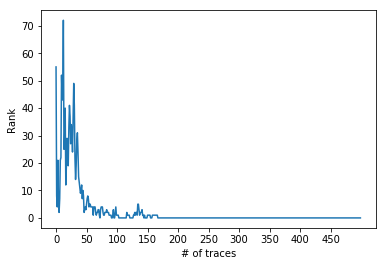

In [32]:
keypred = pd.DataFrame(keyprediction)
plt.plot(keypred.index.values[0:500], keypred[0][0:500])
plt.xlabel('# of traces')
plt.ylabel('Rank')
plt.xticks(np.arange(0, 500, step=50))
plt.show()

In [35]:
print(key[0][0:0+2])

de
